# NOTEBOOK LLAMA 3.2 - BINARY CLASSIFICATION (ZERO-SHOT)

This notebook evaluates the Llama LLM using zero-shot prompting for binary classification, distinguishing between normal and attack.

## 1. OBJECTIVES

The objective of this notebook is to evaluate the performance of the Llama LLM in a **zero-shot binary classification** setting.

Specifically, this notebook aims to:
- Test the model's ability to distinguish between **normal** and **malicious** traffic without prior examples.
- Analyze the model's predictions and assess its suitability for binary threat detection tasks in IoT systems.


## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, and evaluation.

In [1]:
# pandas, json, re and os imports
import pandas as pd
import json
import os
import re
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# imports for LLM training
from datasets import Dataset, DatasetDict
from huggingface_hub import interpreter_login
from unsloth import FastLanguageModel
# imports for evaluation (sklearn)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# tqdm import
from tqdm import tqdm

# Login to Hugging Face Hub
interpreter_login()

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



## 3. PREPARE LLM

Load the Llama language model from Unsloth with specific configuration parameters.

In [2]:
# Define model loading parameters
max_seq_length = 2048 
dtype = None 
load_in_4bit = True

# Load the Llama 3.2 LLM with Unsloth's FastLanguageModel utility
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-unsloth-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4060 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Test one sample

In [3]:
# Sample IoT log entry to classify
log_entry = """
- The length of the DNS query is: 0.0
- The MQTT protocol name used is: 0.0
- The MQTT message type is: 0.0
- The MQTT topic is: 0.0
- The MQTT connection acknowledgment flags are: 0.0
- TCP options set in the packet are: 0101080a9b1f90b39ead21c3
- TCP destination port is: 80.0
"""

question = f"""You are a cybersecurity LLM trained to analyze raw IoT traffic logs.

Your task is to classify the log entry below as either:

- Attack (if there is any indication of malicious behavior),
- Normal (if the traffic seems safe).

Respond:
- Attack (if there is any indication of malicious behavior), or
- Normal (if the traffic seems safe).

Do NOT explain. Do NOT write anything else only NORMAL or ATTACK. 

### Log Entry:
{log_entry}
Response:"""

In [5]:
# Model is ready for inference
FastLanguageModel.for_inference(model)

# Tokenize input
inputs = tokenizer([question], return_tensors="pt").to("cuda")

# Generate response
outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=3,
    use_cache=True
)

# Decode and extract response
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract the generated response
generated_part = response.replace(question, "").strip()
print(">>> Extracted response:")
print(generated_part)


>>> Extracted response:
Attack


## 4. PREPARE DATASET

The dataset is split into 70% for training, 15% for validation, and 15% for testing. However, only the **test split** is used in this notebook for zero-shot evaluation. 

These results will later be compared with the outcomes from the few-shot and fine-tuning experiments.


In [6]:
# Define file path
file_path = "../../../data/prompts/binary_instructions.jsonl"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Read JSONL file line by line
samples = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line.strip()) 
        samples.append({"text": sample["Prompt"]})

# Convert into Hugging Face Dataset format
dataset_dict = {"full": Dataset.from_list(samples)}
dataset = DatasetDict(dataset_dict)

# Verify first example
print(dataset["full"][0])

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n### Instruction:\nYou are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide a response if this log data indicates a potential attack or normal traffic.\n### Question:\n- The length of the DNS query is: 0\n- The MQTT protocol name used is: 0\n- The MQTT message type is: 0\n- The MQTT topic is: 0\n- The MQTT connection acknowledgment flags are: 0\n- TCP options set in the packet are: 0\n- TCP destination port is: 53316.0\n### Response:\n<think>\nThis log data is normal traffic.\n</think>'}


In [7]:
# Shuffle the dataset
dataset = dataset["full"].shuffle(seed=42)

# Split dataset into train (70%), validation (15%), test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))

# Ensure the split sizes are correct
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# Print sizes
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Samples: 8400
Validation Samples: 1800
Test Samples: 1800


## 5. DEFINE HELPER FUNCTIONS FOR PREDICTIONS

This section defines two helper functions:

- `extract_and_format_log`: Formats the input log into a prompt compatible with the LLM.
- `extract_true_label`: Extracts the true label associated with each input sample for evaluation.

In [8]:
def extract_and_format_log(json_text):
    match = re.search(r'### Question:\n(.*?)### Response:', json_text, re.DOTALL)
    if match:
        log_entry = match.group(1).strip()
        log_entry = "\n".join(line.strip() for line in log_entry.split("\n") if line.strip())

        # Zero-shot prompt
        prompt = f"""You are a cybersecurity LLM trained to analyze raw IoT traffic logs.

        Your task is to classify the log entry below as either:

        - Attack (if there is any indication of malicious behavior),
        - Normal (if the traffic seems safe).

        Respond:
        - Attack (if there is any indication of malicious behavior), or
        - Normal (if the traffic seems safe).

        Do NOT explain. Do NOT write anything else only NORMAL or ATTACK. 

        ### Log Entry:
        {log_entry}
        Response:"""

        return prompt
    else:
        return None


In [9]:
# Function to extract the true label from the JSON response text
def extract_true_label(json_text):
    match = re.search(r'### Response:\n<think>\nThis log data is (.*?)\.', json_text, re.IGNORECASE)
    if match:
        return "Attack" if "attack" in match.group(1).lower() else "Normal"
    return "Unknown"

## 6. COMPUTE PREDICTIONS

In this section, predictions are generated using the LLM and stored in a list. The corresponding true labels are also collected in a separate list. 

Both lists will be used later to compute evaluation metrics.

In [10]:
# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over each sample in the test dataset with a progress bar
for sample in tqdm(test_dataset, desc="Processing test samples"):
    # Transform the log text into the required prompt format
    formatted_prompt = extract_and_format_log(sample["text"])
    true_label = extract_true_label(sample["text"])

    if not formatted_prompt or true_label == "Unknown":
        continue  # Skip samples where log extraction fails or label is unknown

    # Tokenize the input text
    inputs = tokenizer([formatted_prompt], return_tensors="pt").to("cuda")

    # Generate the model's response
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=10,
        use_cache=True
    )

    # Decode the model's output into a readable string
    response_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    # Extract the last response from the generated text
    last_response = None
    for line in reversed(response_text.splitlines()):
        if "attack" in line.lower():
            last_response = "Attack"
            break
        elif "normal" in line.lower():
            last_response = "Normal"
            break
    if last_response:
        predicted_label = last_response
    else:
        predicted_label = "Unknown"
    predictions.append(predicted_label)
    true_labels.append(true_label)


Processing test samples: 100%|██████████| 1800/1800 [13:05<00:00,  2.29it/s]


## 7. Compute Evaluation Metrics

In this section, standard evaluation metrics are computed to assess the model's performance. These include Accuracy, Precision, Recall, F1-Score, and the Confusion Matrix.

In [11]:
# Compute classification metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="weighted", zero_division=0)
recall = recall_score(true_labels, predictions, average="weighted", zero_division=0)
f1 = f1_score(true_labels, predictions, average="weighted", zero_division=0)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.5139
Precision: 0.4991
Recall: 0.5139
F1 Score: 0.4028


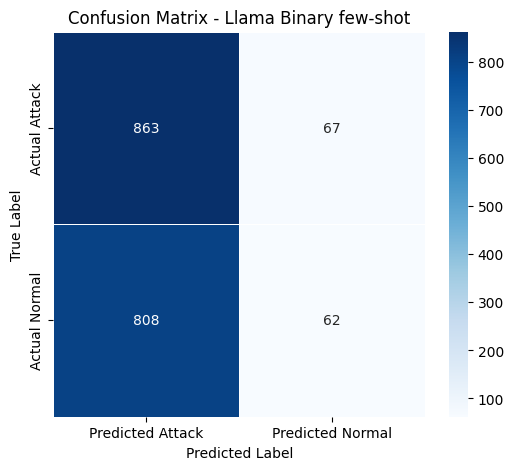

In [12]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=["Attack", "Normal"])

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Attack", "Actual Normal"], columns=["Predicted Attack", "Predicted Normal"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Llama Binary few-shot")
plt.show()